In [1]:
import os
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from matplotlib import colors

parser = argparse.ArgumentParser()
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true', default=True)
parseGroup1.add_argument('--PhiRing',        action='store_true', default=False)
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true', default=False)
parseGroup2.add_argument('--l1MatchGen',     action='store_true', default=True)


#args = parser.parse_args()
args = parser.parse_args("--ChunkyDonut --l1MatchGen".split()) # to run in jupyter-notebook 
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen


sIpFileName     = "../data/L1T_Jet_MLInputs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv"
sOpFileName_SFs = "../data/L1T_Jet_SFs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv"
sOutDir         = "./plots"

iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV

sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 


data_all = pd.read_csv(sIpFileName)
print("Input file: %s" % (sIpFileName))
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))

Input file: ../data/L1T_Jet_MLInputs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sL1Jet: L1JetEt_PUS_ChunkyDonut, 		 sRefJetEt: GenJetEt


In [2]:
print("data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'GenJetEt', 'nVertexGen', 'nMeanPUGen', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt',
       'L1JetDefault_PUEt_ChunkyDonut', 'L1Jet9x9_RawEt',
       'L1Jet9x9_EtSum7PUTowers', 'L1Jet9x9_PUEt_ChunkyDonut'],
      dtype='object'), 
data_all.shape: (18218932, 15)


In [3]:
data_all[sL1JetEt_PUS_ChunkyDonut] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']

data_all[sL1JetEt_PUS_PhiRing]     = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )

sL1JetEt_forML              = 'log_%s' % (sL1JetEt)
sRefJetEt_forML             = 'log_%s' % (sRefJetEt)
data_all[sL1JetEt_forML]    = np.log(data_all[sL1JetEt])
data_all[sRefJetEt_forML]   = np.log(data_all[sRefJetEt])

print("\nsL1JetEt_forML: {}, sRefJetEt_forML: {}\n".format(sL1JetEt_forML, sRefJetEt_forML))

print("data_all.describe(): {}".format(data_all.describe()))


sL1JetEt_forML: log_L1JetEt_PUS_ChunkyDonut, sRefJetEt_forML: log_GenJetEt

data_all.describe():         runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  18218932.0       1.821893e+07  1.821893e+07  1.821893e+07   
mean          1.0       1.444852e+04  4.912329e+06  4.917846e+01   
std           0.0       8.523267e+03  2.897911e+06  9.442895e+00   
min           1.0       2.000000e+00  3.410000e+02  0.000000e+00   
25%           1.0       7.160000e+03  2.434180e+06  4.300000e+01   
50%           1.0       1.414000e+04  4.807572e+06  5.000000e+01   
75%           1.0       2.187400e+04  7.436836e+06  5.600000e+01   
max           1.0       2.941200e+04  1.000000e+07  9.200000e+01   

           GenJetEt    nVertexGen    nMeanPUGen  L1JetDefault_Et  \
count  1.821893e+07  1.821893e+07  1.821893e+07     1.821893e+07   
mean   1.386184e+02  4.975521e+01  4.917846e+01     1.378540e+02   
std    1.268615e+02  1.181372e+01  9.442895e+00     1.279238e+02   
min    3.000012e+

In [4]:
## data cleaning--------

# Drop entries with L1JetEt < L1JetPtThrsh
data_all_L1EtBelowThrsh = data_all[ data_all[sL1JetEt] < L1JetPtThrsh ]
print("data_all[ data_all['{}'] < {} ]: {}".format(sL1JetEt, L1JetPtThrsh, data_all_L1EtBelowThrsh))
data_all.drop(index=data_all_L1EtBelowThrsh.index, inplace=True)

print("Does any of the columns have NaN entries: \ndata_all.isna().sum(): {}".format(data_all.isna().sum()))
print("\nAfter cleaning, data_all.describe(): \n{}".format(data_all.describe()))

data_all[ data_all['L1JetEt_PUS_ChunkyDonut'] < 10.0 ]:           runNumber  lumiSectionNumber  eventNumber  nVertexReco   GenJetEt  \
35                1                  9         2734           55   8.494193   
38                1                  9         2739           54  14.118650   
78                1                  9         2756           51  44.941246   
84                1                  9         2758           49   7.298351   
102               1                  9         2771           42  30.310617   
...             ...                ...          ...          ...        ...   
18218795          1              26513      9014356           24  50.380184   
18218811          1              26513      9014364           31   4.765135   
18218822          1              26513      9014374           50   5.093503   
18218881          1              26513      9014399           64  10.236115   
18218887          1              26513      9014403           35  14.846414

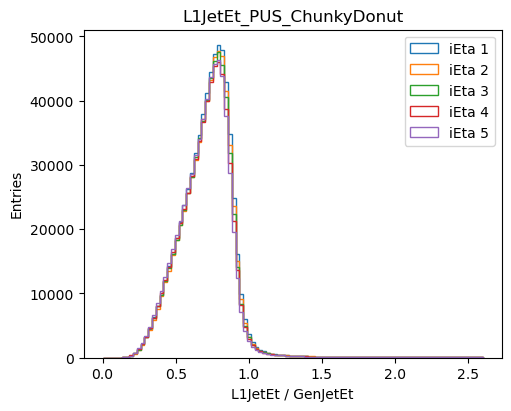

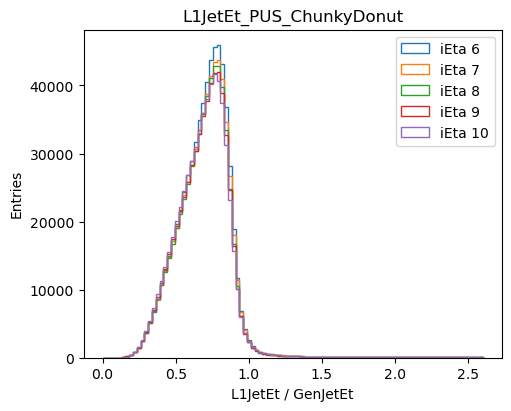

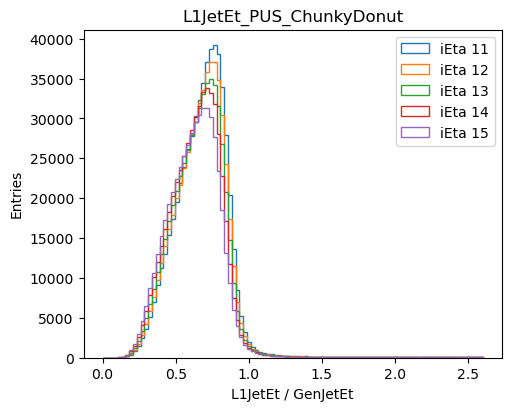

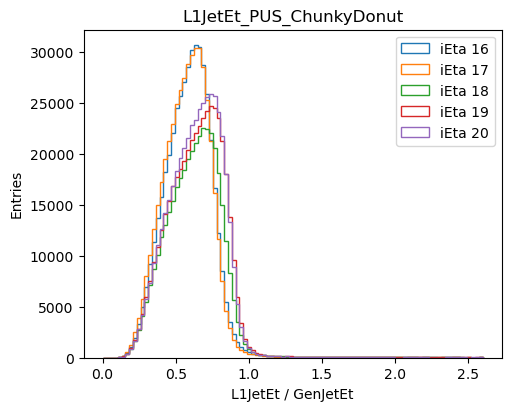

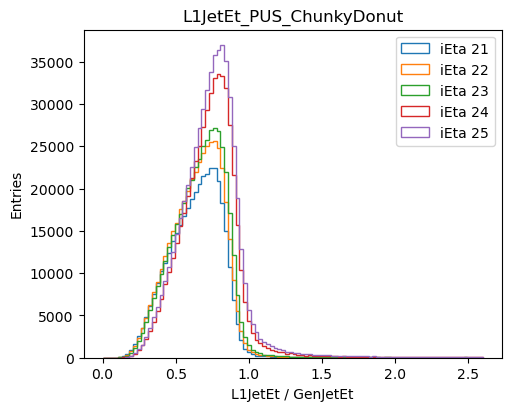

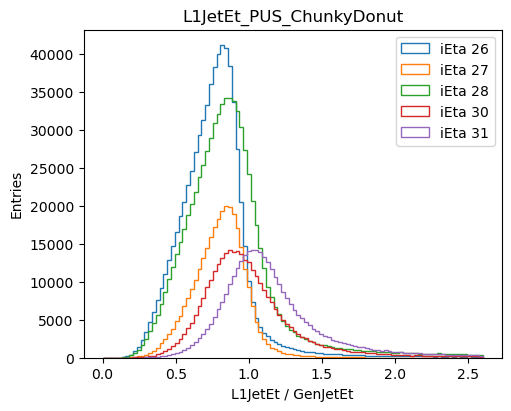

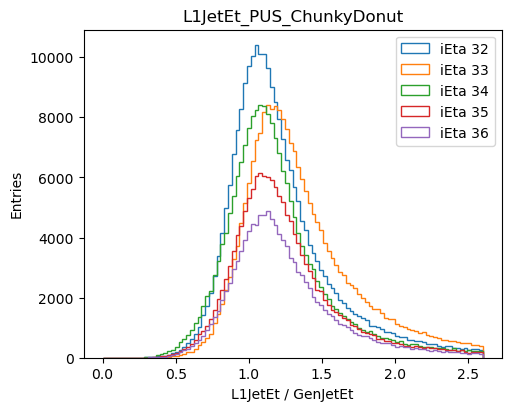

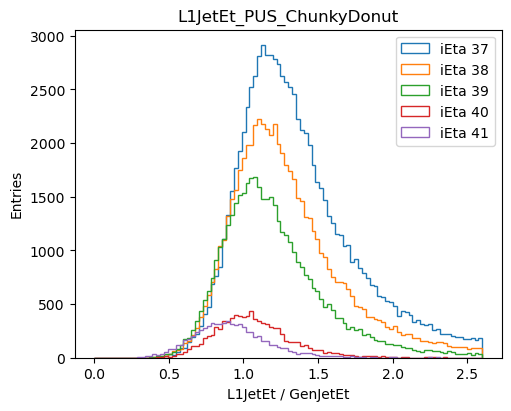

In [5]:
## make resolution plots before JEC

if not os.path.exists(sOutDir): 
    os.makedirs(sOutDir)

#print("".format())
for iEtaBinRange in np.array_split(iEtaBins, 8):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        
    
    for iEtaBin in iEtaBinRange:
        data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step'#, linewidth=2
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Entries')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/beforeJEC_%s_ieta_%d_to_%d.png' % (sOutDir, sL1JetEt, iEtaBinRange[0], iEtaBinRange[-1]))
        
        
